<a href="https://colab.research.google.com/github/KaylumCassidy/BMCA3/blob/main/Copy_of_DATA4001FYP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#DATA4001 Final Project Image-Based Video Game Genre Classification with Deep Neural Networks

In this project, we aim to develop a deep learning model that can automatically classify video games into their respective genres based on images or visual content. Video game genre classification is a valuable application of computer vision and deep learning, with potential uses in recommendation systems, content tagging, and more. The project will focus on leveraging deep learning techniques to accurately identify and classify video game genres from in-game screenshots or cover art.

##  Importing Libraries

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report

In [2]:

# System libraries
from pathlib import Path
import os.path
import random

# Visualization Libraries
import matplotlib.cm as cm
import cv2
import seaborn as sns
import itertools

In [3]:
pip install split-folders


In [4]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import torchvision
from torchvision import datasets, models, transforms
import time
import copy
import splitfolders

## Importing data via Kaggle API

In [6]:
!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
!kaggle datasets download -d aditmagotra/gameplay-images


100% 2.50G/2.51G [00:37<00:00, 88.7MB/s]
100% 2.51G/2.51G [00:37<00:00, 71.3MB/s]


In [8]:
!ls /content/


gameplay-images.zip  kaggle.json  sample_data


In [ ]:
!unzip "gameplay-images.zip" -d /content/my-dataset

In [10]:
import os

# Specify the directory where your dataset is located
dataset_directory = 'my-dataset/Dataset'

# List the contents of the dataset directory
contents = os.listdir(dataset_directory)

# Print the contents
for item in contents:
    if os.path.isdir(os.path.join(dataset_directory, item)):
        print(f"Directory: {item}/")
    else:
        print(f"File: {item}")

Directory: God of War/
Directory: Among Us/
Directory: Fortnite/
Directory: Roblox/
Directory: Terraria/
Directory: Genshin Impact/
Directory: Apex Legends/
Directory: Minecraft/
Directory: Forza Horizon/
Directory: Free Fire/


## Divide our dataset into train and val

In [11]:
data_dir = 'my-dataset/Dataset'
splitfolders.ratio('my-dataset/Dataset', output=data_dir, seed=1337, ratio=(0.8, 0.2, 0))

Copying files: 10000 files [00:12, 788.42 files/s]


In [12]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),  # Randomly crop a portion of the image and resize it to 224x224
        transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
        transforms.ToTensor(),  # Convert the image to a torch.FloatTensor
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize the image
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),  # Resize the image to 256x256
        transforms.CenterCrop(224),  # Crop a 224x224 portion from the center of the image
        transforms.ToTensor(),  # Convert the image to a torch.FloatTensor
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize the image
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=2)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(f"Train size: {dataset_sizes['train']}")
print(f"Validation size: {dataset_sizes['val']}")
print(f"The notebook is running on {device}")


Train size: 8000
Validation size: 2000
The notebook is running on cpu


##  EDA & Visualization

In [13]:
import glob

# Define the directory path to your gameplay data
path = 'my-dataset/Dataset'

# Use glob to list all .jpg files in the specified directory and its subdirectories
path_imgs = list(glob.glob(path + '/**/*.png', recursive=True))

# Extract labels from the file paths
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], path_imgs))

# Create a Pandas Series for file paths and labels
file_path = pd.Series(path_imgs, name='File_Path', dtype=str)
labels = pd.Series(labels, name='Labels', dtype=str)

# Create a DataFrame by concatenating the file paths and labels
data = pd.concat([file_path, labels], axis=1)

# Shuffle the data
data = data.sample(frac=1).reset_index(drop=True)

# Display the first few rows of the DataFrame
data.head()

,File_Path,Labels
0,my-dataset/Dataset/Terraria/image_69.png,Terraria
1,my-dataset/Dataset/Free Fire/image_762.png,Free Fire
2,my-dataset/Dataset/God of War/image_108.png,God of War
3,my-dataset/Dataset/train/God of War/image_549.png,God of War
4,my-dataset/Dataset/train/Genshin Impact/image_...,Genshin Impact


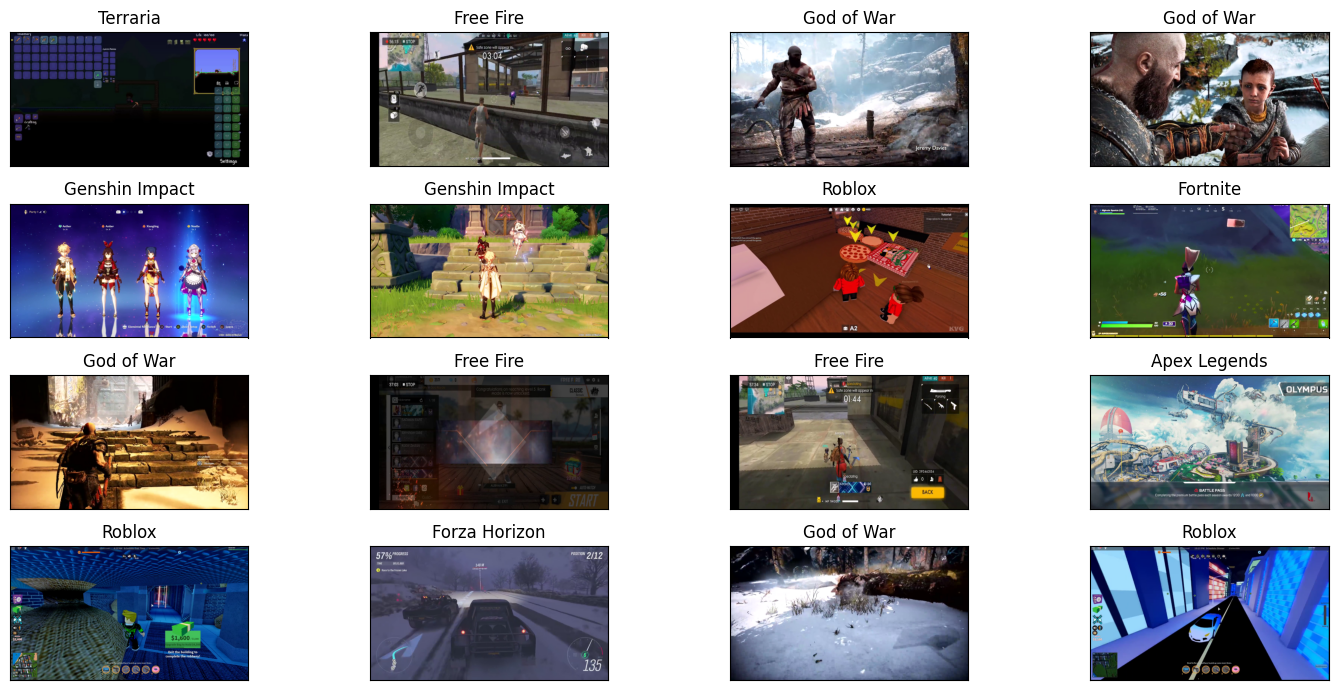

In [14]:


# Define the number of rows and columns in the grid
nrows = 4
ncols = 4

# Create a 4x4 grid of subplots for visualization
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 7), subplot_kw={'xticks': [], 'yticks': []})

# Loop through the subplots and display images with labels
for i, ax in enumerate(axes.flat):
    if i < len(data):
        # Load and display an image from the 'File_Path' and set the title as 'Labels'
        ax.imshow(plt.imread(data.File_Path[i]))  # Display the image
        ax.set_title(data.Labels[i])  # Set the title as the label
    else:
        # If there are no more images in the dataset, remove the empty subplot
        fig.delaxes(ax)

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()


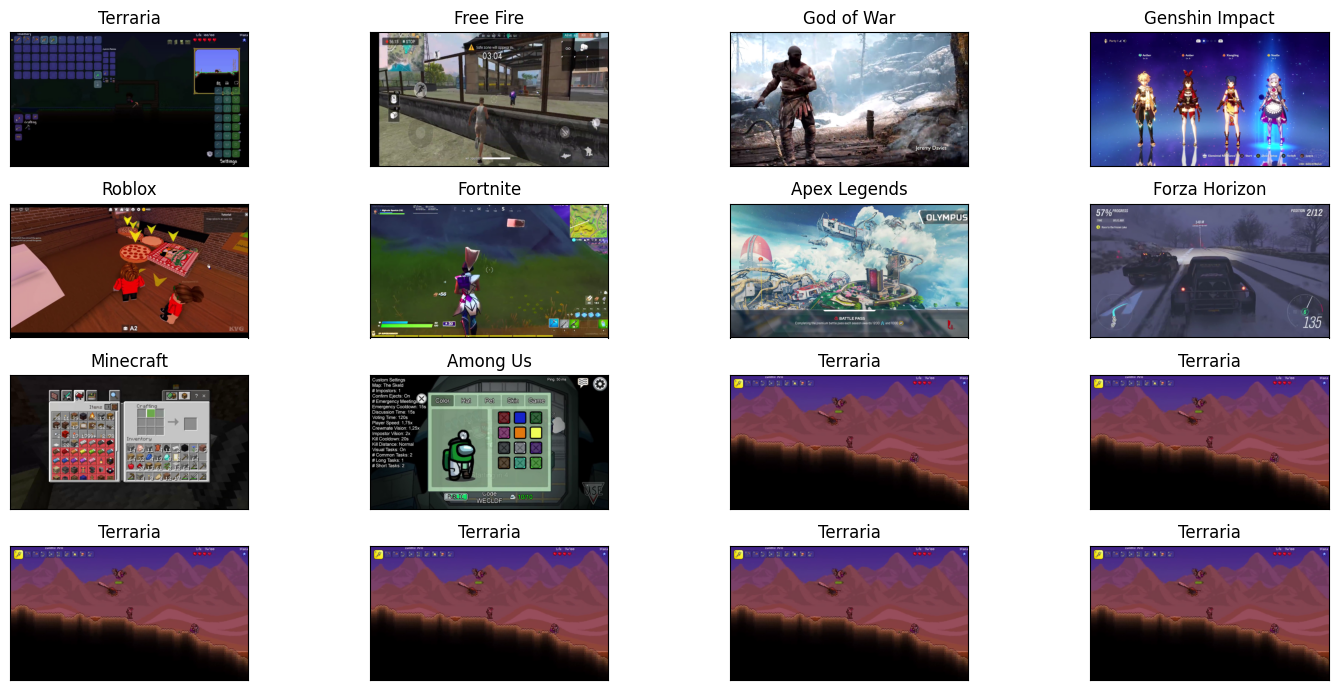

In [15]:


# Create a list to keep track of seen game classes
seen_classes = set()

# Create a 4x4 grid of subplots for visualization
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15, 7), subplot_kw={'xticks': [], 'yticks': []})

# Loop through the subplots and display one image from each game class
for i, ax in enumerate(axes.flat):
    # Find the next image with a new game class
    while data.Labels[i] in seen_classes and i < len(data) - 1:
        i += 1

    # Add the current game class to the set of seen classes
    seen_classes.add(data.Labels[i])

    # Load and display the selected image from the 'File_Path'
    ax.imshow(plt.imread(data.File_Path[i]))  # Display the image
    ax.set_title(data.Labels[i])  # Set the title as the label

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()


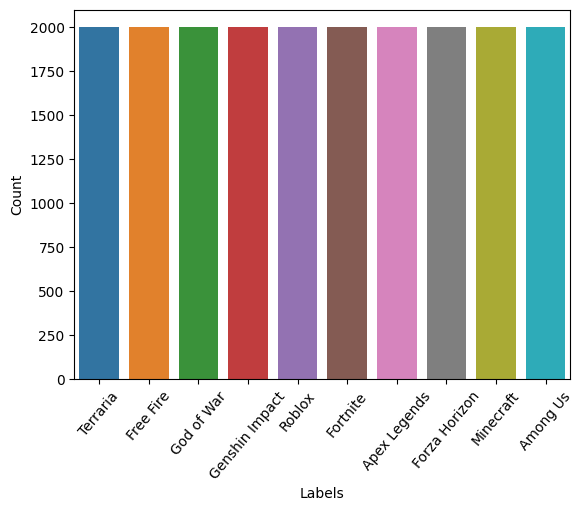

In [16]:
counts = data.Labels.value_counts()
sns.barplot(x=counts.index, y=counts)
plt.xlabel('Labels')
plt.ylabel('Count')
plt.xticks(rotation=50);

All data seen to be find and able to use

##Data Visualization
Let's look at the images after augmentations

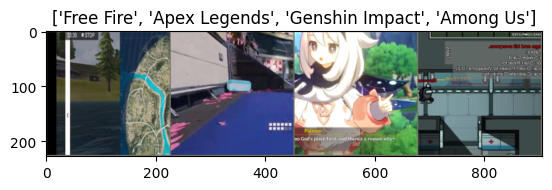

In [17]:
# Define the imshow function
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # Pause for updating

# Get a batch from the 'train' dataloader
inputs, classes = next(iter(dataloaders['train']))

# Create a grid from the batch
out = torchvision.utils.make_grid(inputs)

# Display the images and their corresponding class labels
imshow(out, title=[class_names[x] for x in classes])

## Computing Error Rate Analysi

The code below is used for error level analysis (ELA) of images in the context of a game image classification task.

In [18]:
# Tensorflow Libraries
from tensorflow import keras
from keras.layers import Dense, Dropout

def compute_ela_cv(path, quality):
    temp_filename = 'temp_file_name.jpeg'
    SCALE = 15
    orig_img = cv2.imread(path)
    orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)

    cv2.imwrite(temp_filename, orig_img, [cv2.IMWRITE_JPEG_QUALITY, quality])

    # read compressed image
    compressed_img = cv2.imread(temp_filename)

    # get absolute difference between img1 and img2 and multiply by scale
    diff = SCALE * cv2.absdiff(orig_img, compressed_img)
    return diff


def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file_name.jpeg'
    ela_filename = 'temp_ela.png'
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)

    ela_image = ImageChops.difference(image, temp_image)

    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1

    scale = 255.0 / max_diff
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)

    return ela_image

def random_sample(path, extension=None):
    if extension:
        items = Path(path).glob(f'*.{extension}')
    else:
        items = Path(path).glob(f'*')

    items = list(items)

    p = random.choice(items)
    return p.as_posix()

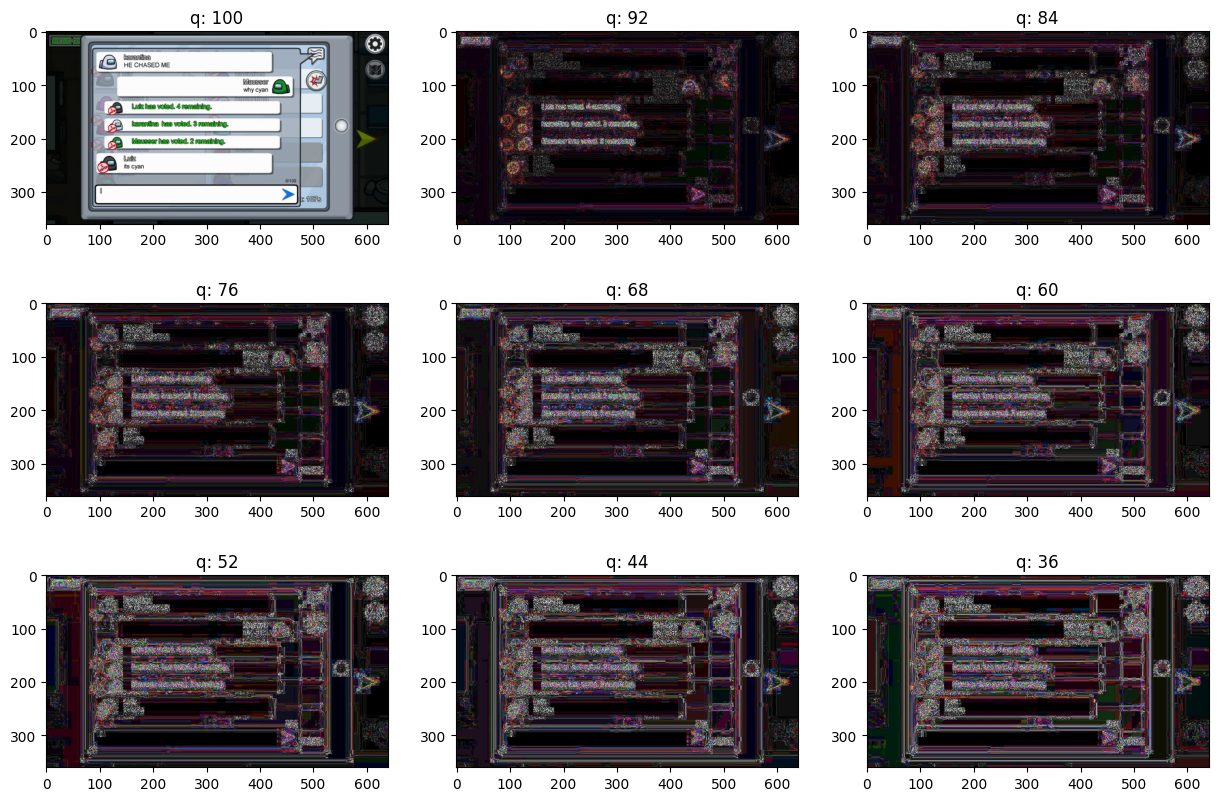

In [19]:
# View random sample from the dataset
p = random_sample('my-dataset/Dataset/Among Us')
orig = cv2.imread(p)
orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB) / 255.0
init_val = 100
columns = 3
rows = 3

fig=plt.figure(figsize=(15, 10))
for i in range(1, columns*rows +1):
    quality=init_val - (i-1) * 8
    img = compute_ela_cv(path=p, quality=quality)
    if i == 1:
        img = orig.copy()
    ax = fig.add_subplot(rows, columns, i)
    ax.title.set_text(f'q: {quality}')
    plt.imshow(img)
plt.show()

Overall, this code provides a way to visually analyze the effect of different levels of JPEG compression on gaming images, and may be used to identify optimal quality levels for image compression in the context of a animals image classification task.

## Train & Test Split

In [126]:
train_df, test_df = train_test_split(data, test_size=0.2, random_state=2)

## Fuctions

In [50]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # There are training and validation phases in each epoch
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set the model in training mode
            else:
                model.eval()   # Set the model in evaluation mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate through batches of data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the gradients
                optimizer.zero_grad()

                # Forward pass through the model
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backpropagation and optimization only in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Calculate accuracy and loss for the batch
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            # Update the learning rate in the training phase
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Save the best model based on validation accuracy
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f} min {time_elapsed % 60:.0f} sec')
    print(f'Best accuracy on validation: {best_acc:4f}')

    # Load the weights of the best model
    model.load_state_dict(best_model_wts)
    return model


In [143]:
def gen(pre,train,test):
    train_datagen = ImageDataGenerator(preprocessing_function=pre, validation_split=0.2)
    test_datagen = ImageDataGenerator(preprocessing_function=pre)

    train_gen = train_datagen.flow_from_dataframe(
        dataframe=train,
        x_col='File_Path',
        y_col='Labels',
        target_size=(100,100),
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='training',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest")
    valid_gen = train_datagen.flow_from_dataframe(
        dataframe=train,
        x_col='File_Path',
        y_col='Labels',
        target_size=(100,100),
        class_mode='categorical',
        batch_size=32,
        shuffle=False,
        seed=0,
        subset='validation',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest")
    test_gen = test_datagen.flow_from_dataframe(
        dataframe=test,
        x_col='File_Path',
        y_col='Labels',
        target_size=(100,100),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        verbose=0,
        shuffle=False)
    return train_gen, valid_gen, test_gen
def func(name_model):
    pre_model = name_model(input_shape=(100,100, 3),
                   include_top=False,
                   weights='imagenet',
                   pooling='avg')
    pre_model.trainable = False
    inputs = pre_model.input
    x = Dense(100, activation='relu')(pre_model.output)
    x = Dense(100, activation='relu')(x)
    outputs = Dense(11, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss = 'categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
    my_callbacks  = [EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=2,
                              mode='auto')]
    return model, my_callbacks

In [128]:
def func(name_model):
    pre_model = name_model(input_shape=(100,100, 3),
                   include_top=False,
                   weights='imagenet',
                   pooling='avg')
    pre_model.trainable = False
    inputs = pre_model.input
    x = Dense(100, activation='relu')(pre_model.output)
    x = Dense(100, activation='relu')(x)
    outputs = Dense(11, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss = 'categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
    my_callbacks  = [EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=2,
                              mode='auto')]
    return model, my_callbacks

In [129]:
def plot(history,test_gen,train_gen,model):
    # Plotting Accuracy, val_accuracy, loss, val_loss
    fig, ax = plt.subplots(1, 2, figsize=(10, 3))
    ax = ax.ravel()

    for i, met in enumerate(['accuracy', 'loss']):
        ax[i].plot(history.history[met])
        ax[i].plot(history.history['val_' + met])
        ax[i].set_title('Model {}'.format(met))
        ax[i].set_xlabel('epochs')
        ax[i].set_ylabel(met)
        ax[i].legend(['Train', 'Validation'])

    # Predict Data Test
    pred = model.predict(test_gen )
    pred = np.argmax(pred,axis=1)
    labels = (train_gen.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    pred = [labels[k] for k in pred]

    # Classification report
    cm=confusion_matrix(test_df.Labels,pred)
    clr = classification_report(test_df.Labels, pred)
    print(clr)
    # Display 6 picture of the dataset with their labels
    fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(12, 8),
                        subplot_kw={'xticks': [], 'yticks': []})

    for i, ax in enumerate(axes.flat):
        ax.imshow(plt.imread(test_df.File_Path.iloc[i+1]))
        ax.set_title(f"True: {test_df.Labels.iloc[i+1]}\nPredicted: {pred[i+1]}")
    plt.tight_layout()
    plt.show()

    return history

In [130]:
def result_test(test,model_use):
    results = model_use.evaluate(test, verbose=0)

    print("    Test Loss: {:.5f}".format(results[0]))
    print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    return results

## Visualizing Model Predictions

In [51]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'Predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)


## Method 1: Finetuning for Convolutional Networks

In [52]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
out_ftrs = len(class_names)
model_ft.fc = nn.Linear(num_ftrs, out_ftrs)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Update weights for the entire model
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decrease LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 85.8MB/s]


In [53]:
model_ft = train_model(model_ft, criterion, optimizer_ft,
                       exp_lr_scheduler, num_epochs=1)

Epoch 0/0
----------
train Loss: 0.8066 Acc: 0.7419
val Loss: 0.1858 Acc: 0.9445

Training complete in 40 min 33 sec
Best accuracy on validation: 0.944500


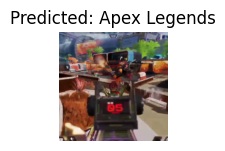

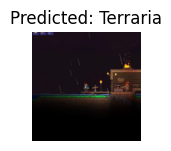

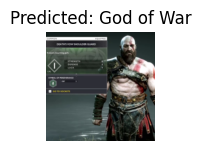

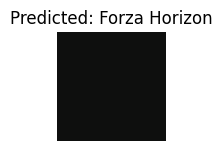

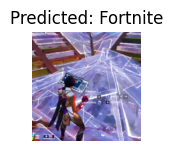

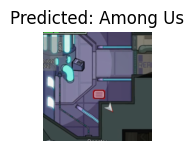

In [54]:
visualize_model(model_ft)

### Saving model for later use

In [94]:
import os

# Define the directory where you want to save the model
model_save_dir = 'model'

# Ensure the directory exists
os.makedirs(model_save_dir, exist_ok=True)

# Define the filename for your model
model_filename = 'your_model.pth'

# Combine the directory and filename to create the full model path
model_save_path = os.path.join(model_save_dir, model_filename)

# Save the model's state dictionary
torch.save(model_ft.state_dict(), model_save_path)

# Now your model is saved at model_save_path


In [95]:

# Create the directory if it doesn't exist
os.makedirs(os.path.dirname(model_save_path), exist_ok=True)


In [97]:
model_save_path = 'model.pth'

# Save the model's state dictionary
torch.save(model_ft.state_dict(), model_save_path)


### Testing the Acc of Gameplay images classification  

In [114]:
import torch
from torchvision import transforms

# Define the preprocessing transformations
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),  # Resize and crop as per your model's input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # ImageNet normalization
])




In [121]:
# Load and preprocess the input image
from PIL import Image
img_path = '/content/Apex-Legends-Mobile_6bwXO9o.webp'
img = Image.open(img_path)
img = preprocess(img)
img = img.unsqueeze(0)  # Add a batch dimension

# Perform inference
model_ft.eval()  # Set the model to evaluation mode
with torch.no_grad():
    outputs = model_ft(img)

# Get the predicted class
_, predicted = torch.max(outputs, 1)
predicted_class = predicted.item()

In [122]:
class_names = ["Minecraft", "Roblox","Among Us", "God of War","Apex Legends","Forza Horizon","Free Fire","Genshin Impact","Terraria"]

predicted_label = class_names[predicted_class]
print(f"Predicted Label: {predicted_label}")


Predicted Label: Apex Legends


## Method 2: Convolutional Network as a Frozen Feature Extractor

In [55]:
model_conv = torchvision.models.resnet18(pretrained=True)

# Freeze the parameters
for param in model_conv.parameters():
    param.requires_grad = False

# The new fully connected layer has requires_grad=True by default
num_ftrs = model_conv.fc.in_features
out_ftrs = len(class_names)
model_conv.fc = nn.Linear(num_ftrs, out_ftrs)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Update weights for only the fully connected layer
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decrease LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)


In [57]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=1)

Epoch 0/0
----------
train Loss: 0.8297 Acc: 0.7302
val Loss: 0.2874 Acc: 0.9050

Training complete in 18 min 25 sec
Best accuracy on validation: 0.905000


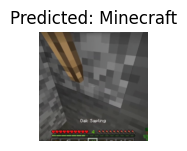

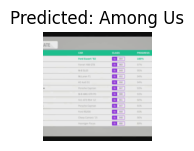

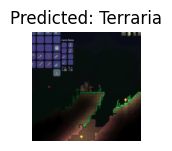

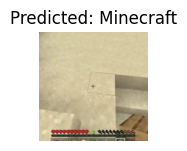

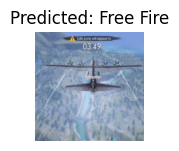

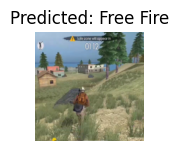

In [58]:
visualize_model(model_conv)

plt.ioff()
plt.show()

### Saving model

In [123]:
import os

# Define the directory where you want to save the model
model_save_dir = 'model'

# Ensure the directory exists
os.makedirs(model_save_dir, exist_ok=True)

# Define the filename for your model
model_filename = 'your_model_2.pth'

# Combine the directory and filename to create the full model path
model_save_path = os.path.join(model_save_dir, model_filename)

# Save the model's state dictionary
torch.save(model_conv.state_dict(), model_save_path)

# Now your model is saved at model_save_pat

### Testing model

In [124]:
# Load and preprocess the input image
from PIL import Image
img_path = '/content/Apex-Legends-Mobile_6bwXO9o.webp'
img = Image.open(img_path)
img = preprocess(img)
img = img.unsqueeze(0)  # Add a batch dimension

# Perform inference
model_conv.eval()  # Set the model to evaluation mode
with torch.no_grad():
    outputs = model_conv(img)

# Get the predicted class
_, predicted = torch.max(outputs, 1)
predicted_class = predicted.item()

In [125]:
class_names = ["Minecraft", "Roblox","Among Us", "God of War","Apex Legends","Forza Horizon","Free Fire","Genshin Impact","Terraria"]

predicted_label = class_names[predicted_class]
print(f"Predicted Label: {predicted_label}")

Predicted Label: Apex Legends
